In [1]:
import os
import numpy as np
import pandas as pd
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D , Dense , Dropout, concatenate , Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets.base import get_data_home
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import multilabel_confusion_matrix


from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import initializers, regularizers, constraints, optimizers, layers

import keras.backend as K



Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../input/vikara-category/cleaned.csv", index_col=False)

In [3]:
#need to convert target to numerical encodings
target_encode = {'depression':0,       
'generic':1,       
'adhd':2,             
'antisocial':3,        
'ocd':4,               
'suicide':5,          
'eatingdisorder':6,     
'anxiety':7}
def map_target(text):
    return taget_encode[text]

dataset['target'] = dataset['target'].map(target_encode)

In [4]:
texts = dataset['clean_tweet']
target = dataset.target

In [5]:
target[:10]

0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: target, dtype: int64

In [6]:
vocab_size = 20000  #there are 17,538 unique words, 20K vocab size is good to start? change and try

tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # Generate sequences

In [7]:
print (len(sequences))
# print (len(sequences[0]))
print(texts[4])
print (sequences[4])

10487
whooo yeah hour night time nap sooooo refreshing insomnia insomniac
[9049, 2428, 568, 243, 26, 4869, 3493, 9050, 20, 4870]


In [8]:
word_index = tokenizer.word_index
print('Found {:,} unique words.'.format(len(word_index)))

Found 17,538 unique words.


In [9]:
# Create inverse index mapping numbers to words
inv_index = {v: k for k, v in tokenizer.word_index.items()}

# Print out text again
for w in sequences[4]:
    x = inv_index.get(w)
    print(x,end = ' ')

whooo yeah hour night time nap sooooo refreshing insomnia insomniac 

In [10]:
#finding average length of tweets - 109 words
print(dataset['clean_tweet'].apply(len).mean())

108.73309812148374


In [11]:
# Get the average length of a text
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(13.167159340135406, 5.450103685069234)

In [12]:
print(pad_sequences([[1,2,3]], maxlen=5))
print(pad_sequences([[1,2,3,4,5,6]], maxlen=5))

[[0 0 1 2 3]]
[[2 3 4 5 6]]


In [13]:
max_length = 100
data = pad_sequences(sequences, maxlen=max_length)

In [14]:
dataset['target'].value_counts()

0    2107
1    1796
2    1591
3    1100
5    1000
4    1000
6     947
7     946
Name: target, dtype: int64

In [15]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(target))
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

print (target[0])
print (labels[0])

Shape of data: (10487, 100)
Shape of labels: (10487, 8)
2
[0. 0. 1. 0. 0. 0. 0. 0.]


## Loading GloVe embeddings


In [16]:
glove_dir = '../input/glove-global-vectors-for-word-representation' # This is the folder with the dataset

embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [17]:
print (embeddings_index['insomnia'])
print (len(embeddings_index['insomnia']))

[-0.03318   -0.4094     0.24339    0.49775   -0.47421    0.3358
  0.50994   -0.14746   -0.0060407 -0.48914   -0.48723   -0.30983
 -0.55801    0.064653   0.97349    0.074214  -0.60807   -0.57678
  0.24427    0.31941   -0.016617  -0.21556   -0.91974    0.58475
 -0.15042    0.49957    0.43522   -0.54141   -0.033027  -0.72702
  0.23126    0.18671   -0.61187    0.65715   -0.57323    0.60046
  0.95418    0.52972    0.66532   -0.056152   0.37789    0.71067
 -0.39626   -0.52342    0.39531    0.070752   0.19562   -0.082394
 -0.014243   0.1077    -0.46232   -0.25654   -0.4465     0.15526
  0.49211   -0.59911    0.86246    0.42481   -0.78216    0.32283
  0.2209     1.1858     0.33707   -0.27468   -0.3159     0.4146
  1.1645    -1.0409     0.87001   -0.67482   -0.74724   -0.21099
  0.25842    0.44037   -0.45538    0.20314   -0.66501    0.40346
 -0.63568    0.22373   -0.26271   -0.2417    -0.46914    0.71003
 -1.3439    -0.074386  -0.12263    0.33859   -1.3835     0.27561
 -0.64083    0.040283   0.

In [18]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
# nb_words = min(vocab_size, len(word_index)) # How many words are there actually
nb_words=20000
embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(20000, 100)

In [20]:
print (embedding_matrix[100])

[-2.07200006e-01  1.37480004e-02 -7.94510007e-01  6.19189978e-01
 -8.29530001e-01  5.27520001e-01  7.09039986e-01 -3.35060000e-01
  7.42200017e-01  1.43859997e-01 -4.13310006e-02  1.44649997e-01
 -7.67430011e-03 -3.37570012e-01  1.00600004e+00  6.61750019e-01
  3.96420002e-01 -1.07410002e+00 -4.29459989e-01  2.68020004e-01
 -6.20229989e-02  2.89330006e-01 -5.88779986e-01  1.01709998e+00
  2.66330004e-01  3.64050001e-01 -2.47199997e-01 -9.84149992e-01
 -2.14809999e-01  7.45429993e-02  5.58669984e-01  5.25470018e-01
 -2.83490002e-01 -3.69709998e-01 -7.84349963e-02  3.26660007e-01
  7.85560012e-01  7.67080009e-01 -6.30930007e-01 -1.80539995e-01
 -1.39510006e-01  8.36570024e-01 -4.49019998e-01 -9.68949974e-01
 -4.80479985e-01  1.18689999e-01  5.22230029e-01  5.84079981e-01
 -2.75489986e-01 -8.02069977e-02  2.71239996e-01 -1.82109997e-01
 -7.76970029e-01  4.16799992e-01  2.35640004e-01 -1.22670002e-01
  7.25090027e-01  5.74919999e-01 -8.43069971e-01  6.80000007e-01
 -8.61420035e-02  7.61659

In [21]:
print(embedding_matrix.shape)

(20000, 100)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [23]:
print("Train data:",X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Train data: (7026, 100) (7026, 8)
Test data: (3461, 100) (3461, 8)


## CNN

In [24]:
class textCNN:
    def __init__(self,sequence_len, max_words, no_classes, embed_dim, filter_size,no_filters,hidden_dims,drop_rate):
        self.sequence_len = sequence_len
        self.max_words = max_words
        self.no_classes = no_classes
        self.embed_dim = embed_dim
        self.filter_size = filter_size
        self.no_filters = no_filters
        self.hidden_dims = hidden_dims
        self.drop_rate = drop_rate


    def cnn_model(self):
        inp = Input(shape = (self.sequence_len,) , name = 'inp')
        embed = Embedding(self.max_words, self.embed_dim, weights = [embedding_matrix], input_length = self.sequence_len ,trainable = True)(inp)
       
        #keep low drop out rate for input
#         embed = Dropout(0.2)
        (embed)
                
        x = self.conv_layer(embed)
        x = Activation('relu')(x)
        output = Dense(self.no_classes, activation='softmax')(x)
        return Model(inputs = inp, outputs = output)

    
 
    
    def conv_layer(self, embed): 
        conv_channels = []
        for i in range(len(self.filter_size)):
            channel = self.each_conv_channel(embed, self.no_filters, self.filter_size[i])
            conv_channels.append(channel)
            if (len(conv_channels)>1):                
                channel = keras.layers.concatenate(conv_channels)
        
        return channel
        
    def each_conv_channel(self, embed, no_filters, filter_size):
        x = Conv1D(no_filters, kernel_size = filter_size, activation = 'relu', strides=1, padding='valid')(embed)
        x = GlobalMaxPooling1D()(x)
            #hidden dense layer
        x = Dense(self.hidden_dims)(x)
        x = Dropout(self.drop_rate)(x)
        return x
        

In [25]:

#from textCNN import textCNN

#deep learning parameters
filter_sizes = [3]
num_filters = 10
dropout_rate = 0.2
hidden_dense_units = 20


#training parameters
no_folds = 2
batch_size = 100
epochs = 5
#lr = 0.001

model_history = []

#model_checkpoint = ModelCheckpoint('cnn_text.h5',monitor='val_loss', verbose=1, save_best_only=True)
def fit_eval(tr_x, val_x, tr_y, val_y):
    model= None
    model = textCNN(    
    sequence_len = max_length,
    max_words = nb_words,
    no_classes = 8,
    embed_dim = embedding_dim,
    filter_size = filter_sizes,
    no_filters = num_filters,
    hidden_dims = hidden_dense_units,
    drop_rate = dropout_rate    
    ).cnn_model()
    
    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    result = model.fit(tr_x, tr_y, epochs = epochs, batch_size = batch_size, callbacks = [EarlyStopping(monitor='loss', patience = 3, verbose = 1) , ModelCheckpoint('cnn_text1.h5',monitor='loss', verbose=1, save_best_only=True)], 
              verbose=1 , validation_data=(val_x, val_y))  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return result
    
    
for i in range(no_folds):
    print("Training on fold ",i+1)
    tr_x, val_x, tr_y, val_y = train_test_split(X_train, y_train, test_size = 0.1, random_state = np.random.randint(1,1000))
    model_history.append(fit_eval(tr_x, val_x, tr_y, val_y))

Training on fold  1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 10)            3010      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
d

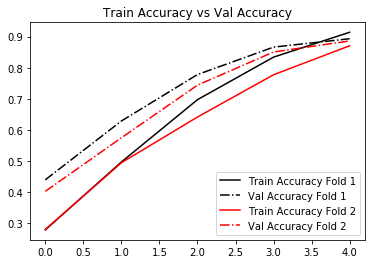

In [26]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.legend()
plt.show()  

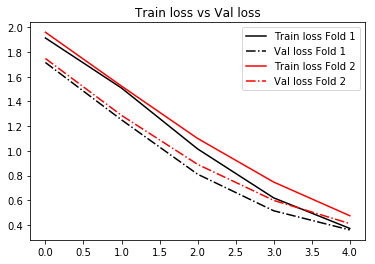

In [27]:
plt.title('Train loss vs Val loss')
plt.plot(model_history[0].history['loss'], label='Train loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val loss Fold 2', color='red', linestyle = "dashdot")
plt.legend()
plt.show() 

In [28]:
y_test = y_test.argmax(axis=1)

In [29]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 1439, 2511,
        157, 3714,  190, 7018,  235,    4, 2538,  279, 5313,  715,  514,
       2565, 3715,    4,  615,  413, 1677,   59,  414,  190,  715, 2103,
         34], dtype=int32)

In [30]:
model = load_model('cnn_text1.h5')
pred = model.predict(X_test)
y_hat = pred.argmax(axis=-1)
y_test_ = y_test.argmax(axis=-1)
# print(y_hat[:10])
print("Accuracy: ",np.mean(y_test_==y_hat))
# print(confusion_matrix(y_test, y_hat))

Accuracy:  0.0


In [31]:
print("Sample predictions:", y_hat[:10])
print("Truth:", y_test[:10])

Sample predictions: [3 4 0 0 3 0 2 0 1 2]
Truth: [3 1 4 0 3 0 2 0 1 2]


In [32]:
print(classification_report(y_test_, y_hat, target_names=labels))

TypeError: Singleton array 11 cannot be considered a valid collection.

In [ ]:
pred_prob = model.predict(X_test)
roc_auc_score(y_test, pred_prob)

In [ ]:
#save tokenizer object https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Attention

In [ ]:
class Attention(Layer):
    #initialise
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shap-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------e) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        #calculations
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [ ]:
inp = Input(shape=(max_length, ))
x = Embedding(nb_words, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(50, return_sequences=True))(x)
#x = Bidirectional(GRU(50,return_sequences=True))(x)
x = Attention(max_length)(x)
x = Dropout(0.5)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
 model.summary()


In [ ]:
# history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(val_X, val_y), verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=1)

In [ ]:
def print_hist(history):
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [ ]:
history.history.keys()

In [ ]:
print_hist(history)

In [ ]:
#testing and metric calculation
# model = load_model('attention.h5')
pred = model.predict(X_test)
y_hat = pred.argmax(axis=-1)
print(y_hat[:10])
y_test_ = y_test.argmax(axis=-1)
print("Accuracy: ",np.mean(y_test_==y_hat))

In [ ]:
labels = ['depression',       
'generic',       
'adhd',             
'antisocial',        
'ocd',               
'suicide',          
'eatingdisorder',     
'anxiety']

In [ ]:
print(classification_report(y_test_, y_hat, target_names=labels))

In [ ]:
# pred_prob = model.predict_proba(X_test)

pred_prob = model.predict(X_test)
roc_auc_score(y_test, pred_prob)

## MLP

In [ ]:
#https://austingwalters.com/classify-sentences-via-a-multilayer-perceptron-mlp/




model = Sequential()

model.add(Dense(512, input_shape=(max_words,))) 
model.add(Activation('tanh'))
model.add(Dropout(0.5))

# Hidden Layer (512) --(W2)--> Output Layer (num_classes)
model.add(Dense(num_classes)) 
model.add(Activation('softmax'))

# Add optimization method, loss function, and optimization value
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# "Fit model" (train model), using training data (80% of data)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Evaluate the trained model, using the test data (20% of data)
score = model.evaluate(x_test, y_test, batch_size=batch_size)

## Usage to predict on raw text

In [ ]:
#prediction on raw sentence
def predict_cnn(sample_):
    model = load_model('cnn_text.h5')
    #to do: preprocess inputs
    
    #load tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    text_ = tokenizer.texts_to_sequences([sample_])
    data_ = pad_sequences(text_, maxlen=max_length)
    pred = model.predict(data_)
    # print(list(target_encode.keys())pred)
    if list(np.argwhere(pred>0.3)) is None:
            
#     pred_list = list(np.argwhere(pred>0.3).flatten())

        pred_list = list(np.argmax(pred).flatten())

    
    tags=[]
    for n in pred_list:
        tags.append((list(target_encode.keys())[n]))
    return tags

In [ ]:
print(predict_cnn("I feel like nowadays getting couple of hours of sleep is getting so hard"))

In [ ]:
print(predict_cnn("The universe has been kind and forgetful and I wish I had the memory for eternity")) 

In [ ]:
print(predict_cnn("Don't feel like eating nowadays at all")) 

## References 
* [Starter code](https://www.kaggle.com/code/carlosaguayo/deep-learning-for-text-classification)
* [Model](https://github.com/sahana-bs/Aggression-Detection-1/blob/master/notebook/cnn.ipynb)